In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

sys.path.append("..")
from utils import (
    filter_noisy_genes,
    generate_k_fold,
    load_model,
    read_aws_h5ad,
    set_seed,
    write_adata_to_s3,
)

set_seed(0)

Seed set


## Load Model from Checkpoint

In [ ]:
# use anndata generate by ..data_processing/inhouse_prior_graph_preprocessing.ipynb
unfilterd_adata = read_aws_h5ad("path to preprocessed h5ad")
adata = filter_noisy_genes(unfilterd_adata)
adata.layers["logcounts"] = adata.X.copy()
adata.X = adata.X.todense()
device = torch.device("cuda:0")
gene_network = adata.uns["sparse_gene_network"].todense()

In [4]:
# subset to powered perturbations
adata.obs["condition"] = adata.obs["condition"].astype(str)
adata.obs["Treatment"] = adata.obs["Treatment"].astype(str)
adata.obs["pert_treat"] = adata.obs["condition"] + "+" + adata.obs["Treatment"]
obs_df = pd.DataFrame(adata.obs["pert_treat"])
category_counts = obs_df["pert_treat"].value_counts()
filtered_categories = category_counts[category_counts >= 50].index
adata = adata[adata.obs["pert_treat"].isin(filtered_categories)]
labels = adata.obs["Treatment"].values

In [22]:
# load model from checkpoint
s3_dir = "s3://pert-spectra/PertSpectra_checkpoints/"
experiment_name = "pertspectra_inhouse/"
model_name = "kfold_4"
wrapper, adata = load_model(
    adata=adata,
    s3_dir=s3_dir,
    experiment_name=experiment_name,
    model_name=model_name,
    use_cell_types=True,
    cell_type_key="Treatment",
)

In [23]:
# save trained PertSpectra parameters
adata.uns["SPECTRA_factors"] = wrapper.factors
adata.uns["SPECTRA_L"] = wrapper.internal_model.L
adata.uns["SPECTRA_pert_scores"] = wrapper.cell_scores

In [24]:
# reconstruct binarized perturbation matrix
pert_idx = list(wrapper.internal_model.pert_idx)
pert_labels = [x.split("_")[-1] for x in wrapper.internal_model.pert_labels]
adata.uns["Spectra_pert_labels"] = pert_labels
D = []
for i in adata.obs["condition"]:
    d = [0.0 for _ in range(len(pert_idx))]
    # add intercept
    d[-1] = 1
    if i == "nan":
        D.append(d)
        continue
    # control
    if i == "ctrl":
        d[-2] = 1.0
        D.append(d)
        continue
    guides = i.split("+")

    # pert or intergenic
    if guides[0] in adata.var_names:
        adata_idx = adata.var_names.get_loc(guides[0])
        one_hot_idx = pert_idx.index(adata_idx)
        d[one_hot_idx] = 1.0
    else:
        one_hot_idx = pert_labels.index(guides[0])
        d[one_hot_idx] = 1.0

    if len(guides) > 1:
        if guides[1] in adata.var_names:
            adata_idx = adata.var_names.get_loc(guides[1])
            one_hot_idx = pert_idx.index(adata_idx)
            d[one_hot_idx] = 1.0
        else:
            one_hot_idx = pert_labels.index(guides[1])
            d[one_hot_idx] = 1.0
    D.append(d)
D = np.stack(D).astype(np.float32)

## Reconstructed Gene Expression
- Visualize reconstructed gene expression for a single perturbation
- Save reconstructed gene expression for all heldout cells

In [49]:
wrapper.internal_model.to(torch.device("cuda:0"))

SPECTRA(
  (theta): ParameterDict(
      (global): Parameter containing: [torch.cuda.FloatTensor of size 4997x20 (cuda:0)]
      (TNFA+): Parameter containing: [torch.cuda.FloatTensor of size 4997x5 (cuda:0)]
      (TNFA-): Parameter containing: [torch.cuda.FloatTensor of size 4997x5 (cuda:0)]
  )
  (alpha): ParameterDict(
      (TNFA+): Parameter containing: [torch.cuda.FloatTensor of size 24x25 (cuda:0)]
      (TNFA-): Parameter containing: [torch.cuda.FloatTensor of size 24x25 (cuda:0)]
  )
  (eta): ParameterDict(
      (global): Parameter containing: [torch.cuda.FloatTensor of size 20x20 (cuda:0)]
      (TNFA+): Parameter containing: [torch.cuda.FloatTensor of size 5x5 (cuda:0)]
      (TNFA-): Parameter containing: [torch.cuda.FloatTensor of size 5x5 (cuda:0)]
  )
  (gene_scaling): ParameterDict(
      (global): Parameter containing: [torch.cuda.FloatTensor of size 4997 (cuda:0)]
      (TNFA+): Parameter containing: [torch.cuda.FloatTensor of size 4997 (cuda:0)]
      (TNFA-): Para

In [ ]:
# retrieve heldout cells
train_idx, val_idx, test_idx = generate_k_fold(
    adata, adata.X, adata.obs["condition"], fold_idx=4
)
loss_weights = np.ones(adata.shape[0])
holdout_adata = adata[test_idx]
train_adata = adata[train_idx]

In [48]:
# visualize reconstructed vs observed expression for cells of a given perturbation
holdout_perts = "RIPK1"
hold_idx = [
    i for i, x in enumerate(holdout_adata.obs["condition"]) if x == holdout_perts
]
X_holdout = torch.from_numpy(holdout_adata.X[hold_idx])
D_holdout = torch.from_numpy(D[hold_idx])
labels_holdout = labels[hold_idx]
loss_weights_holdout = torch.from_numpy(loss_weights[hold_idx])

In [50]:
with torch.no_grad():
    loss, recon = wrapper.internal_model.loss(
        X=X_holdout,
        D=D_holdout,
        labels=labels_holdout,
        loss_weights=loss_weights_holdout,
        forward=True,
    )

In [53]:
mean_reconstruction = torch.mean(recon["TNFA+"], dim=0).detach().cpu().numpy()
observed = torch.from_numpy(
    holdout_adata[
        (holdout_adata.obs["Treatment"] == "TNFA+")
        & (holdout_adata.obs["condition"] == holdout_perts)
    ].X
)
mean_observed = torch.mean(observed, dim=0).detach().cpu().numpy()

In [ ]:
from scipy.stats import spearmanr

spearmans = spearmanr(mean_reconstruction, mean_observed)

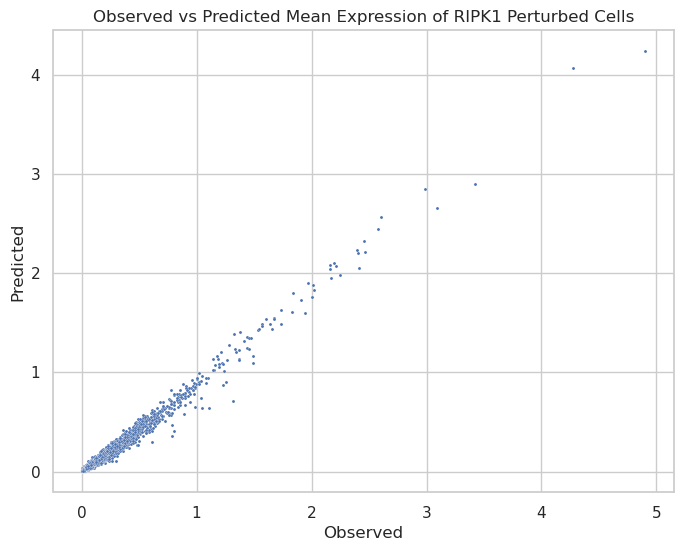

Spearman correlation: SignificanceResult(statistic=0.9771781192927307, pvalue=0.0)


In [57]:
# Plot with Seaborn
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")

sns.scatterplot(x=mean_observed, y=mean_reconstruction, s=5)
plt.title(f"Observed vs Predicted Mean Expression of {holdout_perts} Perturbed Cells")
plt.ylabel("Predicted")
plt.xlabel("Observed")

plt.show()

# Print Spearman correlation
print(f"Spearman correlation: {spearmans}")

In [38]:
# get reconstruction for all heldout samples
X_holdout = torch.from_numpy(holdout_adata.X)
D_holdout = torch.from_numpy(D[test_idx])
labels_holdout = labels[test_idx]
loss_weights_holdout = torch.from_numpy(np.ones(holdout_adata.shape[0]))
recons = []
losses = []
with torch.no_grad():
    for i in range(0, len(X_holdout), 10000):
        loss, recon = wrapper.internal_model.loss(
            X=X_holdout[i : i + 10000],
            D=D_holdout[i : i + 10000],
            labels=labels_holdout[i : i + 10000],
            loss_weights=loss_weights_holdout[i : i + 10000],
            forward=True,
        )
        losses.append(loss["TNFA+"].detach().cpu().numpy())
        recons.append(recon["TNFA+"].detach().cpu().numpy())
adata.uns["recon"] = np.concatenate(recons)
adata.uns["losses"] = np.array(losses)

## Save anndata for downstream analysis

In [39]:
# save anndata for downstream analysis
from scipy import sparse

adata.X = sparse.csr_matrix(adata.X)
write_adata_to_s3(s3_dir + experiment_name, "fold_4", adata)